In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import time
import copy
from numba import jit
import struct
from bisect import bisect_left

In [2]:
def func_factory(x1,x2,y1,y2):
    return lambda x: ((y2-y1)/(x2-x1)) * (x - x1) + y1

In [3]:
def create_func_list(x_values, r_value):
    y_values = np.multiply(x_values, r_value) * np.subtract(1, x_values)
    func_list = []
    for i in range(len(x_values)):
        if i+1 < len(x_values):
            func_list.append(func_factory(x_values[i],x_values[i+1],y_values[i],y_values[i+1]))  
    return func_list

In [4]:
def piecewise_apprx(x, x_values, func_list):
    x = max(min(x,1),0)
    idx = -1
    try:
        idx = min(int(x * len(func_list)), len(func_list)-1)
        return max(min(func_list[idx](x),1),0)
    except:
        print(f"idx={idx}  x={x}   r={r}")
        return 0
#     # get the pos of the x in the list of values
#     pos = bisect_left(x_values, x)
#     # return the value from the matching function
#     if pos != 0:    
#         return func_list[pos-1](x)
#     else:
#         return func_list[pos](x)

In [27]:
class PWApprx:

    def __init__(self, x_values, r):
        self.x_values = x_values
        self.r = r
        self.func_list = self.__create_func_list(x_values, r)  
        self.slope_list = self.__create_slope_list(x_values, r)      
    
    def compute(self, x):
        # clamp x to between zero and one
        x = max(min(x,1),0)
        idx = -1
        try:
            idx = min(int(x * len(self.func_list)), len(self.func_list)-1)
            return max(min(self.func_list[idx](x),1),0)
        except:
            print(f"idx={idx}  x={x}   r={self.r} func")
            return 0
        
    def slope(self, x):
        # clamp x to between zero and one
        x = max(min(x,1),0)
        idx = -1
        try:
            # multiply x by the length of the list conveted to an integer will give us what bin x should go to
            idx = min(int(x * len(self.slope_list)), len(self.slope_list)-1)
            return self.slope_list[idx]
        except:
            print(f"idx={idx}  x={x}   r={self.r} slope")
            return 0

    # private methods 
    
    def __create_func_list(self, x_values, r_value):
        y_values = np.multiply(x_values, r_value) * np.subtract(1, x_values)
        func_list = []
        for i in range(len(x_values)):
            if i+1 < len(x_values):
                func_list.append(self.__func_factory(x_values[i],x_values[i+1],y_values[i],y_values[i+1]))  
        return func_list
    
    def __func_factory(self, x1,x2,y1,y2):
        return lambda x: ((y2-y1)/(x2-x1)) * (x - x1) + y1
    
    def __create_slope_list(self, x_values, r_value):
        y_values = np.multiply(x_values, r_value) * np.subtract(1, x_values)
        slope_list = []
        for i in range(len(x_values)):
            if i+1 < len(x_values):
                slope_list.append((y_values[i+1]-y_values[i])/(x_values[i+1]-x_values[i]))
        return slope_list


In [23]:
def lin_aprx_web_plot(x_0, r, n_points, nmax = 100, savepng = False):
    
    X = np.arange(0,1,.001)
    
    x_values = np.round(np.linspace(0, 1, n_points+2), 3)
    y_values = np.multiply(x_values, r) * np.subtract(1, x_values)
    
#   print(x_values, y_values)

    fig = plt.figure(figsize=(10.5, 8))
    ax = fig.gca()
    
    plt.plot(X, r * X * (1 - X), c = '#AAAAAA') # curve
    plt.plot(x_values, y_values)  # linear approximation graph
    
    func_list = create_func_list(x_values, r)
    cond_list = [False for i in range(len(func_list))]
    
    print(len(func_list),n_points)
    
    x_plots = np.empty(nmax+1)
    y_plots = np.empty(nmax+1)
    
    x_plots[0] = x_0
    y_plots[0] = 0
    
    
    for n in range(1, nmax, 2):
        # Vertical Lines:
        # the x value is the same but the y value changes based on the function (curve)
        x_plots[n] = x_plots[n-1]
        y_plots[n] = piecewise_apprx(x_plots[n], x_values, func_list)
        
#         x = x_plots[n]
        
#         # find the place in the list closest to x and not going over
#         pos = bisect_left(x_values, x)
#         # set the cond to true to use the matching func
#         cond_list[pos-1] = True
          
#         # piecewise function calculates the y value using the conditions and functions  
#         y_plots[n] = np.piecewise(x, cond_list, func_list)
        
#         # reset condition list
#         cond_list[pos-1] = False
        
#         y_plots[n] = np.piecewise(x, 
#         [
#             (x <= x_values[1]),
#             ((x_values[1] < x) & (x <= x_values[2])),
#             ((x_values[2] < x) & (x <= x_values[3])),
#             ((x_values[3] < x) & (x <= x_values[4])),
#             ((x_values[4] < x) & (x <= x_values[5])),
#             (x_values[5] < x)
#         ],
#         func_list                
#         )
        
#         print(x_plots[n],y_plots[n])
        
        # Horizontal Lines
        # the y value is the same but the the new x value = y value as the diagonal line is y = x
        x_plots[n+1] = y_plots[n]
        y_plots[n+1] = y_plots[n]
    
    plt.plot(x_plots, y_plots, c = 'r') 
    plt.plot(X, X, c = 'black', linestyle=":") # line y = x

    maxy = 1.0
    
    line = [[-0.01, maxy+0.1], [-0.01, maxy+0.1]] #line for y = x on the plt
    xaxes = [0, 0,             -0.06, 1.01] #line for the x axis
    yaxes = [-0.06, maxy+0.01, 0, 0] #line for the y axis
    #plt.grid(True)
    xs = np.arange(-0.1, 1.1, 0.05) #  list of xticks 
    ys = np.arange(0,maxy+0.1, 0.05) # list of yticks
    xticks = [] #this is for the labels on the xticks
    
    # setting up the list of strings for the xtick labels
    for i in range(len(xs)):
        if i%2 == 1:
            xticks.append("")
        else:
            xticks.append(str(np.floor(100*xs[i])/100))
            
    
    ax.set_xticks(xs) # set the x ticks (on the axis)
    ax.set_yticks(ys) # set the y ticks (on the axis)
    ax.set_xticklabels(xticks) #set the labels on the xticks
    # plt.locator_params(axis='x', nbins=12)
    plt.grid(True)  #draw the grid
    
    plt.plot(xaxes[0:2], yaxes[0:2], c="k")   # x axis in black
    plt.plot(xaxes[2:4], yaxes[2:4], c="k")   # y axis in black
    
    
    plt.suptitle("Linear Approximation")
    plt.title("r = " + str(r) + " n = " + str(n) + " x = " + str(x_plots[-1]) + " # of points = " + str(n_points))
    if savepng:
        plt.savefig("aprx web r = " + str(r) + " n = " + str(n) + " # of points = " + str(n_points) + ".png")
    
    plt.show()

8 7


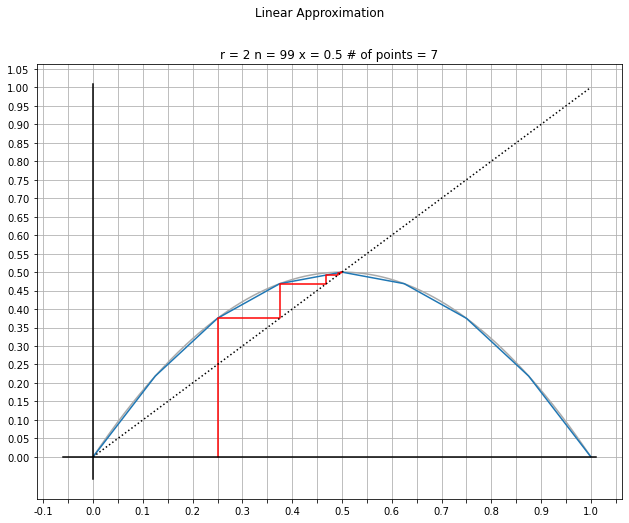

In [7]:
lin_aprx_web_plot(.25, 2, 7, nmax = 100, savepng = False)

In [8]:
def lin_aprx_bif_plot(x_0, n_points, n = 100, savepng = False):
    
    r_values = np.arange(2, 4, .001) #.0001)

    x_values = np.round(np.linspace(0, 1, n_points+2), 3)
#     print(f" num x's = {len(x_values)}")

    fig = plt.figure(figsize = (11,8.5), tight_layout=True)
    fig.patch.set_facecolor('white')

    #x = x_0
    bf_r = []
    bf_x = []
    
    #with np.nditer([func_lists, x_init, r], flags=["refs_ok"], op_flags=[['readonly'],['readwrite'],['readonly']]) as it:
    for rs in r_values:
        x = x_0
        func_list = create_func_list(x_values, rs)
        for j in range(700):
            x = piecewise_apprx(x, x_values, func_list)
        for j in range(n):
            bf_x.append(x)
            bf_r.append(rs)
            x = piecewise_apprx(x, x_values, func_list)
    """
    for idx, x in enumerate(r):
        for j in range(700):
            x_init[idx] = value2(func_lists[idx], x_init[idx], r[idx])
        for j in range(n):
            bf_x.append(x_init[idx])
            bf_r.append(r[idx])
            x_init[idx] = value2(func_lists[idx],  x_init[idx], r[idx])
    
    for i in range(len(r)):
        x = x_0
        
        for j in range(700):
            x_init[i] = value2(func_lists[i], x_init[i], r[i])
            
        for j in range(n):
            bf_x.append(x_init[i])
            bf_r.append(r[i])
            x_init[i] = value2(func_lists[i], x_init[i], r[i])
    """

#     print(f"len of bf_x = {len(bf_x)} and len of bf_r = {len(bf_r)}")
        
    plt.scatter(bf_r,bf_x,s =.001, c= 'black')
    
    # set y and x ticks
    # plt.xticks(np.linspace(1,4,11))
    plt.grid()

    plt.xlabel('r')
    plt.ylabel('x')
    
    plt.suptitle("Linear Approximation")
    plt.title("$x_0$ =" + str(x_0) + " n=" + str(n) + " # of points = " + str(n_points))
    
    if(savepng):
        fig.savefig("lin_aprx_bif_x_0=" + str(x_0) + "_#ofpoints=" + str(n_points)  + ".png", bbox_inches='tight')
    
    plt.show()

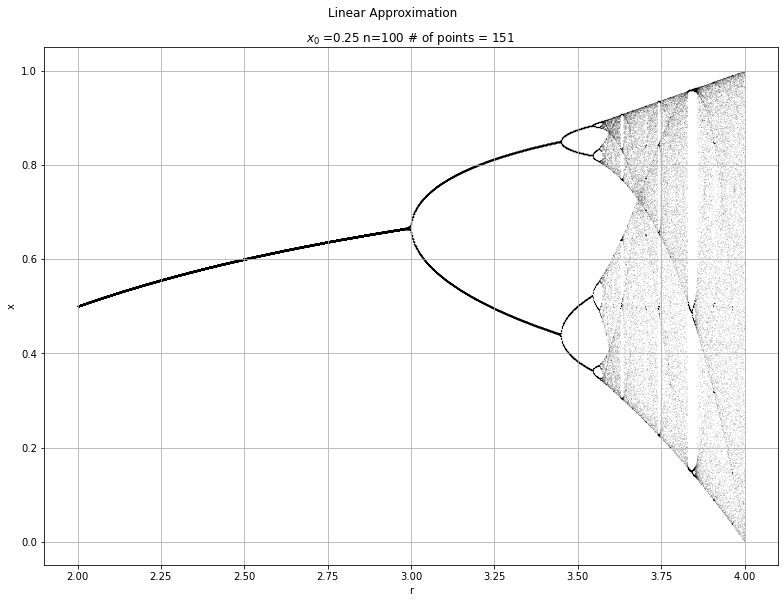

In [9]:
lin_aprx_bif_plot(.25, 151, n = 100, savepng = False)

In [10]:
def lyapunov_fractal_apprx(nmax, a_lb = 2, a_ub = 4, b_lb = 2 , b_ub = 4, x_0 = 0.5, n_points = 5, savepng = False, savetofile = False):
    
    @jit
    def F_prime(x, r, epsilon = 0):
        return np.log(np.add(np.abs(np.multiply(rb, (np.subtract(1, (np.multiply(2, x.T))))).T), epsilon))
    
    start = time.time()
    
    n_warmups = 1200
    
#     step_size = .001
    
#     ra = np.arange(ra_start, ra_end, step_size)
#     rb = np.arange(rb_start, rb_end, step_size)

    steps = 500
    
    ra = np.linspace(a_lb, a_ub, steps)
    rb = np.linspace(b_lb, b_ub, steps)
    
    x = [ [x_0 for a in range(len(ra))] for b in range(len(rb))]
    x = np.asarray(x)

    # lin approximation
    
    x_values = np.round(np.linspace(0, 1, n_points+2), 3) # values of x on the curve that will be used to create the approximation
    
    
    func_list_a = [0 for a in range(len(ra))]
    
    
    for a_i, a in enumerate(ra):
        func_A = PWApprx(x_values, a)
        func_list_a[a_i] = func_A

    if a_lb == b_lb and a_ub == b_ub:
        
        func_list_b = [0 for b in range(len(rb))]

        for b_i, b in enumerate(rb):
            func_B = PWApprx(x_values, b)
            func_list_b[b_i] = func_B
            
    else:
        func_list_b = func_list_a
                
    for i in range(n_warmups):
        if i % 10 == 0:
            print("warmup:",i)
        for b_i, b in enumerate(rb):
            for a_i, a in enumerate(ra):
                if i % 2 == 0:
                    x[a_i][b_i] = func_list_a[a_i].compute(x[a_i][b_i])
                else:  
                    x[a_i][b_i] = func_list_b[b_i].compute(x[a_i][b_i])
        
#     for i in range(n_warmups):
#         for a_i, a in enumerate(ra):
#             if i % 2 == 0:
#                 x[a_i] = func_list_a[a_i].compute(x[a_i])
#         for b_i, b in enumerate(rb):
#             if i % 2 == 1:  
#                 x = x.T
#                 x[b_i] = (func_list_b[b_i].compute([b_i]))
#                 x = x.T
        
    lya_grid = 0
    epsilon = 1e-20
    
    for i in range(nmax):
        if i % 10 == 0:
            print("lyap:",i)
        if i % 2 == 0:
            lya_grid = np.add(lya_grid , F_prime(x, ra))    
        else: 
            lya_grid = np.add(lya_grid , F_prime(x, rb))        
        for b_i, b in enumerate(rb):
            for a_i, a in enumerate(ra):
                if i % 2 == 0:
                    x[a_i][b_i] = func_list_a[a_i].compute(x[a_i][b_i])
#                     lya_grid = np.add(lya_grid , F_prime(x, ra, epsilon))
                else:  
                    x[a_i][b_i] = func_list_b[b_i].compute(x[a_i][b_i])
#                     lya_grid = np.add(lya_grid , F_prime(x, rb, epsilon))

    
    
    
    lya_grid = np.divide(lya_grid, nmax)
    
#     lya_grid = -1 * lya_grid
    
    if savetofile:
        f = open("fractal_apprx n_points= " + str(n_points) + " steps=" + str(steps) + ".dat", "wb")
        lya_grid = np.ascontiguousarray(lya_grid)
        f.write(lya_grid)
        f.close()
    
    fig, ax = plt.subplots(figsize=(10, 9))
    
    fig.patch.set_facecolor('white')
    
#     lya_cmap = copy.copy(mpl.cm.get_cmap('viridis'))
    lya_cmap = copy.copy(mpl.cm.get_cmap('jet'))
    lya_cmap.set_over('black')
    
#     lya_cmap.set_bad('black')
    
    plt.imshow(lya_grid , cmap = lya_cmap, origin = 'lower', vmax=0) # , norm=mpl.colors.LogNorm(vmin= 1e-4 , vmax=5))
    
    plt.colorbar()
    plt.suptitle("Lyapunov Logistic Fractal - Linear Apprx")
    plt.title("iterations = " + str(nmax + n_warmups) + " n_points = " + str(n_points))  
    
 #   plt.
    
    xticks = np.arange(a_lb, a_ub, .2)
    yticks = np.arange(b_lb, b_ub, .2)
    
    plt.xlabel("A")  
    plt.ylabel("B") 
    
    plt.xticks([])
    plt.yticks([])
    
    if(savepng):
        plt.savefig("fractal_apprx n_points = "+ str(n_points) +".png")
    
    plt.show()
    
    end = time.time()

    print("This took", end - start, "seconds to execute")
    

In [11]:
lyapunov_fractal_apprx(120, n_points = 101, savepng = True, savetofile = True)

warmup: 0
idx=89  x=0.8729664895561479   r=3.0140280561122244
warmup: 10


KeyboardInterrupt: 

In [46]:
def lyapunov_invariat_measure_fractal_apprx(nmax, a_lb = 2, a_ub = 4, b_lb = 2 , b_ub = 4, x_0 = 0.5, n_points = 5, savepng = False, savetofile = False):
    
    def linear_derivative(x, equation):
        return np.abs(equation.slope(x))
                      
                      
    
    start = time.time()
    
    n_warmups = 1200
    
#     step_size = .001
    
#     ra = np.arange(ra_start, ra_end, step_size)
#     rb = np.arange(rb_start, rb_end, step_size)

    steps = 500
    
    ra = np.linspace(a_lb, a_ub, steps)
    rb = np.linspace(b_lb, b_ub, steps)
    
    x = [ [x_0 for a in range(len(ra))] for b in range(len(rb))]
    x = np.asarray(x)

    # lin approximation
    
    x_values = np.round(np.linspace(0, 1, n_points+2), 3) # values of x on the curve that will be used to create the approximation
    
    
    func_list_a = [0 for a in range(len(ra))]
    
    
    for a_i, a in enumerate(ra):
        func_A = PWApprx(x_values, a)
        func_list_a[a_i] = func_A

    if a_lb == b_lb and a_ub == b_ub:
        
        func_list_b = [0 for b in range(len(rb))]

        for b_i, b in enumerate(rb):
            func_B = PWApprx(x_values, b)
            func_list_b[b_i] = func_B
            
    else:
        func_list_b = func_list_a
                
    for i in range(n_warmups):
        if i % 10 == 0:
            print("warmup:",i)
        for b_i, b in enumerate(rb):
            for a_i, a in enumerate(ra):
                if i % 2 == 0:
                    x[a_i][b_i] = func_list_a[a_i].compute(x[a_i][b_i])
                else:  
                    x[a_i][b_i] = func_list_b[b_i].compute(x[a_i][b_i])
        
    lya_grid = [ [0 for a in range(len(ra))] for b in range(len(rb))]
    epsilon = 1e-20
    
    for i in range(nmax):
        if i % 10 == 0:
            print("lyap:",i)
        for b_i, b in enumerate(rb):
            for a_i, a in enumerate(ra):
                if i % 2 == 0:
                    x[a_i][b_i] = func_list_a[a_i].compute(x[a_i][b_i])
                    lya_grid[a_i][b_i] = np.add(lya_grid[a_i][b_i], np.log(linear_derivative(x[a_i][b_i], func_list_a[a_i])))
                else:  
                    x[a_i][b_i] = func_list_b[b_i].compute(x[a_i][b_i])
                    lya_grid[a_i][b_i] = np.add(lya_grid[a_i][b_i], np.log(linear_derivative(x[a_i][b_i], func_list_b[b_i])))
    
    lya_grid = np.divide(lya_grid, nmax)
    
#     lya_grid = -1 * lya_grid
    
    if savetofile:
        f = open("invariat_fractal_apprx n_points= " + str(n_points) + " steps=" + str(steps) + ".dat", "wb")
        lya_grid = np.ascontiguousarray(lya_grid)
        f.write(lya_grid)
        f.close()
    
    fig, ax = plt.subplots(figsize=(10, 9))
    
    fig.patch.set_facecolor('white')
    
#     lya_cmap = copy.copy(mpl.cm.get_cmap('viridis'))
    lya_cmap = copy.copy(mpl.cm.get_cmap('jet'))
    lya_cmap.set_over('black')
    
#     lya_cmap.set_bad('black')
    
    plt.imshow(lya_grid , cmap = lya_cmap, origin = 'lower', vmax = 0) # , norm=mpl.colors.LogNorm(vmin= 1e-4 , vmax=5))
    
    plt.colorbar()
    plt.suptitle("Lyapunov Logistic Fractal - Linear Apprx")
    plt.title("iterations = " + str(nmax + n_warmups) + " n_points = " + str(n_points))  
    
 #   plt.
    
    xticks = np.arange(a_lb, a_ub, .2)
    yticks = np.arange(b_lb, b_ub, .2)
    
    plt.xlabel("A")  
    plt.ylabel("B") 
    
    plt.xticks([])
    plt.yticks([])
    
    if(savepng):
        plt.savefig("invariat_fractal_apprx n_points = "+ str(n_points) +".png")
    
    plt.show()
    
    end = time.time()

    print("This took", end - start, "seconds to execute")
    

In [47]:
lyapunov_invariat_measure_fractal_apprx(120, n_points = 101, savepng=True, savetofile=True)

warmup: 0


KeyboardInterrupt: 